In [122]:
#필요한 라이브러리
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [123]:
fraud_data = pd.read_csv(r"C:\Users\user\OneDrive\문서\과제\2024-2\아이펠\fraud.csv")

In [124]:
#나이계산
fraud_data['trans_date_trans_time'] = pd.to_datetime(fraud_data['trans_date_trans_time'])
fraud_data['dob'] = pd.to_datetime(fraud_data['dob'])

fraud_data['age'] = fraud_data.apply(
    lambda row: row['trans_date_trans_time'].year - row['dob'].year - (
        (row['trans_date_trans_time'].month, row['trans_date_trans_time'].day) <
        (row['dob'].month, row['dob'].day)
    ),
    axis=1
)


In [125]:
#년도, 월, 시간, 요일 추출
fraud_data['trans_date_trans_time'] = pd.to_datetime(fraud_data['trans_date_trans_time'])
fraud_data['year'] = fraud_data['trans_date_trans_time'].dt.year
fraud_data['month'] = fraud_data['trans_date_trans_time'].dt.month
fraud_data['hour'] = fraud_data['trans_date_trans_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['trans_date_trans_time'].dt.dayofweek

In [126]:
#컬럼 이름 변경
fraud_data.rename(columns={
    'cc_num': 'card_num',
    'is_fraud': 'fraud',
    'city_pop': 'merch_city_pop'
}, inplace=True)

fraud_data.columns


Index(['trans_date_trans_time', 'card_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'merch_city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'fraud', 'age', 'year', 'month', 'hour',
       'day_of_week'],
      dtype='object')

In [127]:
#시간대 생성
def time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

fraud_data['day_time'] = fraud_data['hour'].apply(time_of_day)


In [128]:
#amt 이상치 감지 변수
fraud_data['amt_zscore'] = fraud_data.groupby('card_num')['amt'].transform(lambda x: (x - x.mean()) / x.std())

In [129]:
#특정 고객에게 발생한 사기 거래 비율
fraud_data['fraud_freq'] = fraud_data.groupby('card_num')['fraud'].transform('mean')

In [130]:
#불필요 컬럼 제거
fraud_data = fraud_data.drop(['trans_date_trans_time', 'street', 'job', 'city', 'state', 'zip', 'lat', 'long', 
                              'unix_time', 'dob', 'first', 'last', 'merchant', 'trans_num'], axis=1)

In [131]:
#주중 주말
fraud_data['weekend'] = fraud_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


In [132]:
fraud_data.head()

,card_num,category,amt,gender,merch_city_pop,merch_lat,merch_long,fraud,age,year,month,hour,day_of_week,day_time,amt_zscore,fraud_freq,weekend
0,630423337322,grocery_pos,107.23,F,149,49.159047,-118.186462,0,40,2019,1,0,1,Night,0.321302,0.001605,0
1,4956828990005111019,grocery_pos,44.71,M,124967,40.079588,-74.848087,0,38,2019,1,0,1,Night,-0.114637,0.002734,0
2,180048185037117,grocery_net,46.28,F,71485,40.021888,-74.228188,0,44,2019,1,0,1,Night,-0.361802,0.003195,0
3,374930071163758,grocery_pos,64.09,M,31515,42.360426,-83.552316,0,47,2019,1,0,1,Night,-0.001304,0.002742,0
4,2712209726293386,misc_pos,25.58,F,378909,29.737426,-90.853194,0,41,2019,1,0,1,Night,-0.393828,0.001144,0


In [133]:
#결측값 처리
missing_values = fraud_data.isnull().sum()
missing_values


card_num          0
category          0
amt               0
gender            0
merch_city_pop    0
merch_lat         0
merch_long        0
fraud             0
age               0
year              0
month             0
hour              0
day_of_week       0
day_time          0
amt_zscore        0
fraud_freq        0
weekend           0
dtype: int64

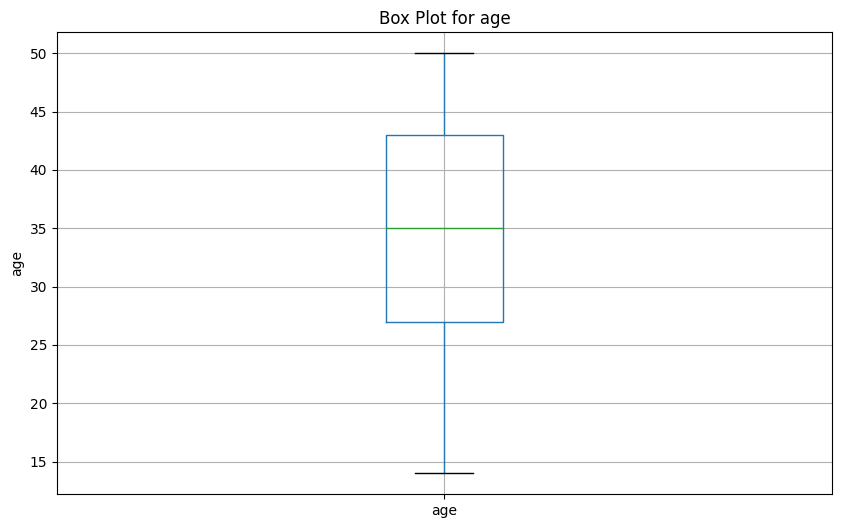

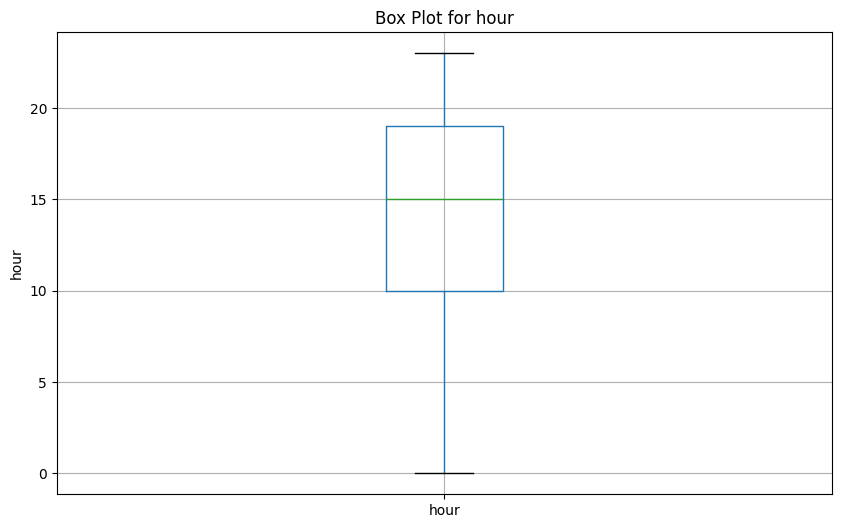

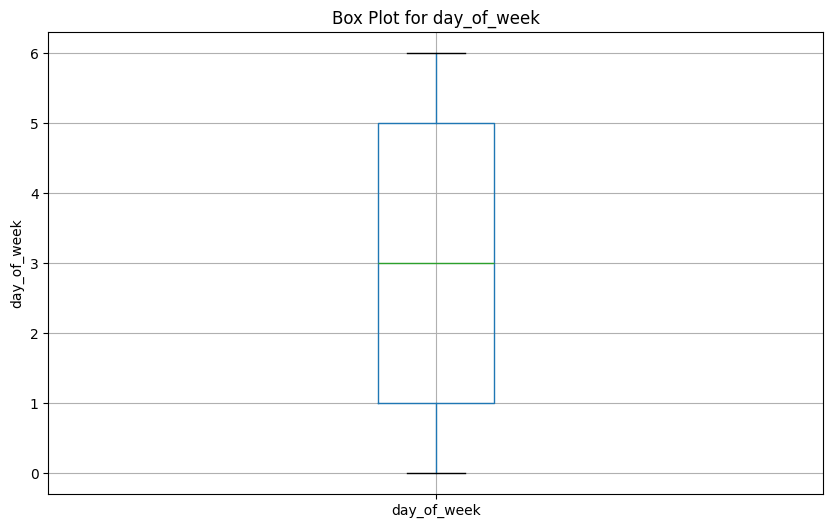

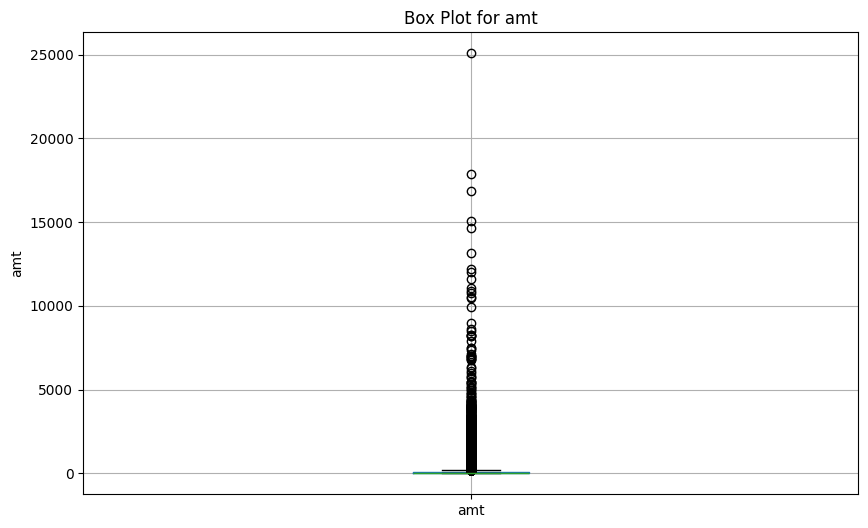

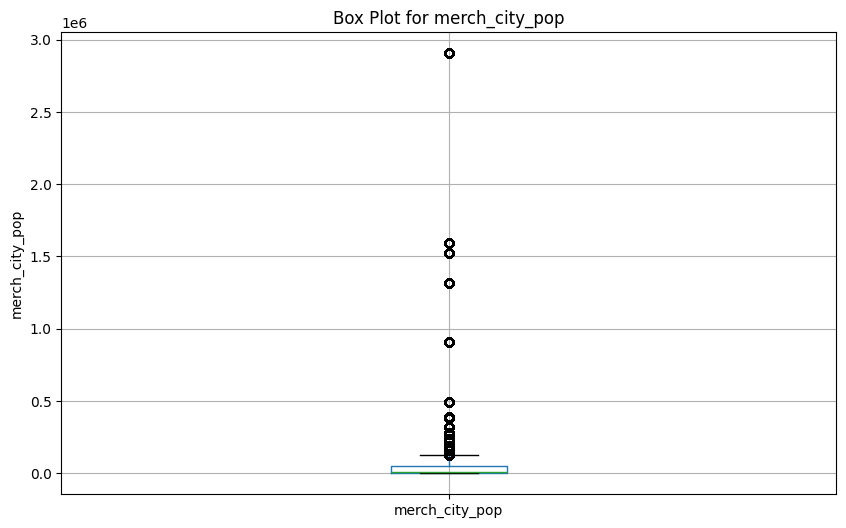

In [134]:
#이상치 탐지
for col in ['age', 'hour', 'day_of_week', 'amt', 'merch_city_pop']:
    plt.figure(figsize=(10, 6))
    fraud_data.boxplot(column=col)
    plt.title(f'Box Plot for {col}')
    plt.ylabel(col)
    plt.show()

In [135]:
#레이블 인코딩
from sklearn.preprocessing import LabelEncoder

string_columns = fraud_data.select_dtypes(include=['object']).columns

label_encoders = {}
for column in string_columns:
    le = LabelEncoder()
    fraud_data[column] = le.fit_transform(fraud_data[column])
    label_encoders[column] = le  

fraud_data.head()

,card_num,category,amt,gender,merch_city_pop,merch_lat,merch_long,fraud,age,year,month,hour,day_of_week,day_time,amt_zscore,fraud_freq,weekend
0,630423337322,4,107.23,0,149,49.159047,-118.186462,0,40,2019,1,0,1,3,0.321302,0.001605,0
1,4956828990005111019,4,44.71,1,124967,40.079588,-74.848087,0,38,2019,1,0,1,3,-0.114637,0.002734,0
2,180048185037117,3,46.28,0,71485,40.021888,-74.228188,0,44,2019,1,0,1,3,-0.361802,0.003195,0
3,374930071163758,4,64.09,1,31515,42.360426,-83.552316,0,47,2019,1,0,1,3,-0.001304,0.002742,0
4,2712209726293386,9,25.58,0,378909,29.737426,-90.853194,0,41,2019,1,0,1,3,-0.393828,0.001144,0


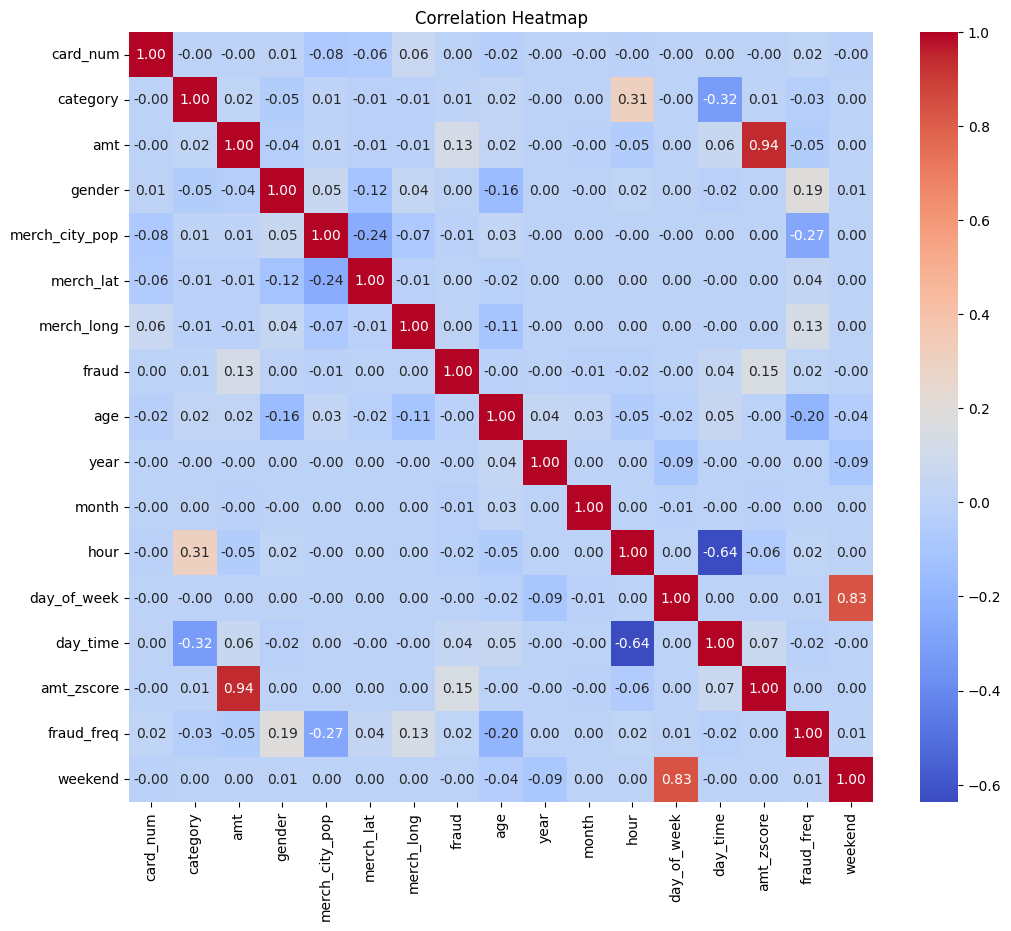

In [136]:
#히트맵 그리기
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = fraud_data.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()
